# Trabalho Final - Aprendizado de Máquina
Ianka Karúzia Rabelo de Oliveira - 365560

Trabalho Realizado com o Dataset **Amazon Fine Food Review**, disponível em: https://www.kaggle.com/snap/amazon-fine-food-reviews/data

Utilizando técnicas de NLP, para realizar Classificações 

In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
import seaborn as sns

In [2]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import re
import string

#### Carregando Banco de Dados

In [3]:
con = sqlite3.connect('database.sqlite')

pd.read_sql_query("SELECT * FROM Reviews LIMIT 5", con)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#### Excluindo as Features Id, ProductId, UserId, ProfileName e Text, além de renomear as Features HelpfulnessNumerator (VotesHelpful) e HelpfulnessDenominator (VotesTotal)

In [4]:
messages = pd.read_sql_query("""
SELECT 
  Score, 
  Summary, 
  HelpfulnessNumerator as VotesHelpful, 
  HelpfulnessDenominator as VotesTotal
FROM Reviews WHERE Score != 3""", con)

In [5]:
messages.head()

,Score,Summary,VotesHelpful,VotesTotal
0,5,Good Quality Dog Food,1,1
1,1,Not as Advertised,0,0
2,4,"""Delight"" says it all",1,1
3,2,Cough Medicine,3,3
4,5,Great taffy,0,0


In [6]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 4 columns):
Score           525814 non-null int64
Summary         525814 non-null object
VotesHelpful    525814 non-null int64
VotesTotal      525814 non-null int64
dtypes: int64(3), object(1)
memory usage: 16.0+ MB


In [7]:
messages['SummaryLenght'] = messages['Summary'].apply(len)

In [8]:
messages.head()

,Score,Summary,VotesHelpful,VotesTotal,SummaryLenght
0,5,Good Quality Dog Food,1,1,21
1,1,Not as Advertised,0,0,17
2,4,"""Delight"" says it all",1,1,21
3,2,Cough Medicine,3,3,14
4,5,Great taffy,0,0,11


### Análise dos Dados

In [9]:
sns.set_style('white')

#### Usando FaceGrid para criar 5 histogramas do tamanho das reviews de acordo com o valor de Score 

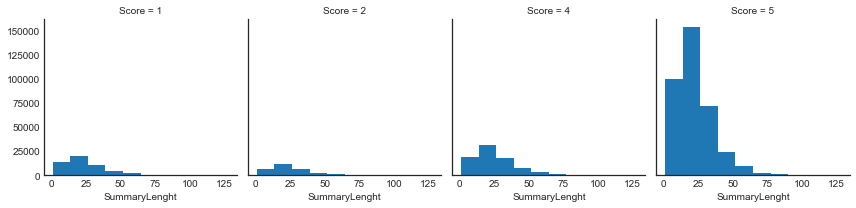

In [10]:
g = sns.FacetGrid(messages, col='Score')
g.map(plt.hist, 'SummaryLenght')

#### Countplot com a quantidade de cada tipo de Score

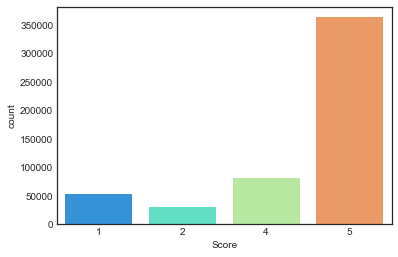

In [11]:
sns.countplot(x='Score', data=messages, palette='rainbow')

#### Utilizando GroupBy para pegar o valor médio das colunas numéricas

In [12]:
scores = messages.groupby('Score').mean()
scores

,VotesHelpful,VotesTotal,SummaryLenght
Score,,,
1,2.735211,4.869825,24.467303
2,1.859014,3.102724,24.899728
4,1.390292,1.666084,24.828988
5,1.675228,1.874108,22.563728


#### Criando um Heatmap baseado nos valores de correlação (.corr) dos dados da variável scores

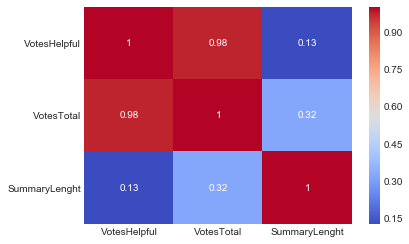

In [13]:
sns.heatmap(scores.corr(), cmap='coolwarm', annot=True)

#### Adicionando a coluna Sentiment que transforma os dados de Score em 1 (Score positivas, ou seja, 4 e 5) e 0 (Scores negativas, 1 e 2)

In [14]:
messages["Sentiment"] = messages["Score"].apply(lambda score: 1 if score > 3 else 0)

#### Na coluna Usefulness foram utilizados os valores das colunas VotesHelpful e VotesTotal para verificar se uma review foi útil (indicado pelo 1) ou não (indicado pelo 0)

In [15]:
messages["Usefulness"] = (messages["VotesHelpful"]/messages["VotesTotal"]).apply(lambda n: 1 if n > 0.8 else 0)

In [16]:
messages[messages.Score == 1].head()

,Score,Summary,VotesHelpful,VotesTotal,SummaryLenght,Sentiment,Usefulness
1,1,Not as Advertised,0,0,17,0,0
12,1,My Cats Are Not Fans of the New Food,1,1,36,0,1
26,1,Nasty No flavor,0,1,15,0,0
47,1,Don't like it,0,7,13,0,0
57,1,stale product.,2,2,14,0,1


In [17]:
messages[messages.Score == 5].head()

,Score,Summary,VotesHelpful,VotesTotal,SummaryLenght,Sentiment,Usefulness
0,5,Good Quality Dog Food,1,1,21,1,1
4,5,Great taffy,0,0,11,1,0
6,5,Great! Just as good as the expensive brands!,0,0,45,1,0
7,5,"Wonderful, tasty taffy",0,0,22,1,0
8,5,Yay Barley,1,1,10,1,1


### Processando os dados textuais

In [27]:
def text_process(sentence):
    #Verifica os caracteres para ver se são pontuaçoes
    nopunc = [char for char in sentence if char not in string.punctuation]
    
    #Une os caracteres novamente para formar a String
    nopunc = ''.join(nopunc)
    #Remove as Stopwords 
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [25]:
s = 'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [26]:
text_process(s)

['I', 'have', 'bought', 'several', 'of', 'the', 'Vitality', 'canned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', 'The', 'product', 'looks', 'more', 'like', 'a', 'stew', 'than', 'a', 'processed', 'meat', 'and', 'it', 'smells', 'better', 'My', 'Labrador', 'is', 'finicky', 'and', 'she', 'appreciates', 'this', 'product', 'better', 'than', 'most']


['bought',
 'several',
 'Vitality',
 'canned',
 'dog',
 'food',
 'products',
 'found',
 'good',
 'quality',
 'product',
 'looks',
 'like',
 'stew',
 'processed',
 'meat',
 'smells',
 'better',
 'Labrador',
 'finicky',
 'appreciates',
 'product',
 'better']

In [21]:
messages["Summary_Clean"] = messages["Summary"].apply(text_process)

#### Wordcloud Para Toda Feature Summary_Clean

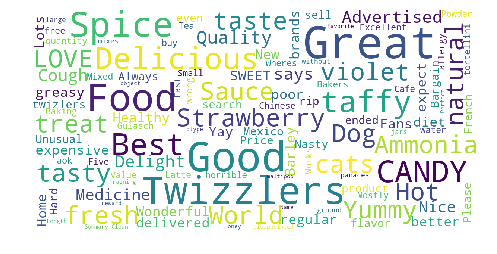

In [25]:
stopwords = set(STOPWORDS)
plt.rcParams['font.size']=12        
plt.rcParams['savefig.dpi']=100 
plt.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(messages["Summary_Clean"])

#### Wordcloud para Piores Avaliações (Score == 1)

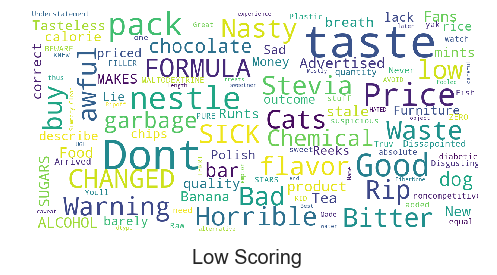

In [30]:
show_wordcloud(messages[messages.Score == 1]["Summary_Clean"], title = "Low Scoring")

#### Wordcloud para Melhores Avaliações (Score == 5)

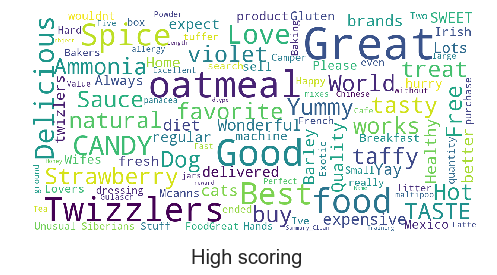

In [31]:
show_wordcloud(messages[messages.Score == 5]["Summary_Clean"], title = "High scoring")

### Falta Fazer:
- CountVectorizer e TfIdfTransformation
- Predição da Feature Sentiment
- Predição da Feature Helfulness